### Importações

In [397]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import os
import sys

In [398]:
%reload_ext autoreload
sys.path.append(os.path.abspath('..'))
from functions.clean_df import load_and_combine_csvs,clean_dataframe,add_confidential_flags
from functions.state_imput import apply_state_estimation
from functions.feature_engineering import feature_engineering
from functions.preprocessing import get_preprocessor

### Criando Dataframe e Aplicando Funções

In [399]:
csv_path = '../raw_data'

df = load_and_combine_csvs(csv_path)

df_clean = clean_dataframe(df)

df_clean = add_confidential_flags(df_clean)

df_clean = apply_state_estimation(df_clean)

df_clean = feature_engineering(df_clean)

In [400]:
df_clean.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,...,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO_ORIGEM,SIGILOSO,ESTADO_ESTIMADO,ID_PORTADOR,FIM_SEMANA,LOG_VALOR
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,41.023.473 EDUARDO MIRANDA DE OLIVEIRA,COMPRA A/V - R$ - APRES,2023-04-24,1350.0,202305_CPGF.csv,0,UNIÃO,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,7.208600
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2023,5,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,...,FERRAGISTA CAPITAL LTDA,COMPRA A/V - R$ - APRES,2023-03-29,163.0,202305_CPGF.csv,0,UNIÃO,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0,5.099866


In [401]:
df_clean['VALOR TRANSAÇÃO'].describe()

count    307307.000000
mean        590.780182
std        2119.947873
min           0.040000
25%         104.000000
50%         256.850000
75%         600.000000
max      207953.600000
Name: VALOR TRANSAÇÃO, dtype: float64

### Funções de Processamento de Dados para Isolation Forest

In [402]:
def add_frequency_features(df, cols_categoria):
    """
    Adiciona colunas de frequência normalizada para cada coluna categórica.
    Ex: 'NOME ÓRGÃO' -> 'FREQ_NOME ÓRGÃO'
    """
    df = df.copy()

    for col in cols_categoria:
        freq_map = df[col].value_counts(normalize=True)
        df[f'FREQ_{col}'] = df[col].map(freq_map)

    return df

In [403]:
def add_monthly_ratio_features(df):
    """
    Cria duas features:
    - MEDIA_VALOR_ORGAO_MES_LOG: média do órgão no ano/mês (log)
    - RATIO_MES: valor da transação dividido pela média original (não log)
    """
    df = df.copy()

    # média original
    df['MEDIA_VALOR_ORGAO_MES'] = (
        df.groupby(['NOME ÓRGÃO', 'ANO EXTRATO', 'MÊS EXTRATO'])['VALOR TRANSAÇÃO']
          .transform('mean')
          .round(2)
    )

    # média em log (evitando log(0))
    df['MEDIA_VALOR_ORGAO_MES'] = (df['MEDIA_VALOR_ORGAO_MES'] + 1).apply(np.log)

    # ratio usando a média original
    df['RATIO_MES'] = df['VALOR TRANSAÇÃO'] / df['MEDIA_VALOR_ORGAO_MES']

    return df

### Processamento de Dados e Criação do Modelo

In [404]:
df_final = df_clean.copy()

In [405]:
cols_categorica = ['NOME ÓRGÃO', 'ESTADO_ESTIMADO', 'NOME FAVORECIDO']
df_final = add_frequency_features(df_final, cols_categorica)

In [406]:
df_final = add_monthly_ratio_features(df_final)

In [408]:
preprocessor = get_preprocessor()
X_scaled = preprocessor.fit_transform(df_final)

# ruido = np.random.normal(0, 1e-5, X_scaled.shape)
# X_scaled = X_scaled + ruido

In [409]:
X_scaled

array([[ 9.49323332e-01, -5.00000000e-01, -4.00000000e-01, ...,
        -1.37681159e-02, -5.89513538e-01,  2.36822942e+00],
       [-2.59373279e-01, -5.00000000e-01, -4.00000000e-01, ...,
         1.44927536e-03, -5.89513538e-01, -1.65525256e-01],
       [ 1.16565495e-01, -5.00000000e-01, -4.00000000e-01, ...,
        -1.37681159e-02, -5.89513538e-01,  1.58931956e-01],
       ...,
       [-1.80341816e-03,  0.00000000e+00,  6.00000000e-01, ...,
         1.84057971e-01,  1.73658735e+00, -7.87215087e-02],
       [-4.48336726e-02,  0.00000000e+00,  6.00000000e-01, ...,
         1.84057971e-01,  1.73658735e+00, -1.10286276e-01],
       [-1.50661441e-01,  0.00000000e+00,  6.00000000e-01, ...,
         1.84057971e-01,  1.73658735e+00, -1.78543598e-01]],
      shape=(307307, 10))

In [410]:
if_model = IsolationForest(contamination=0.01, random_state=42)

if_model.fit(X_scaled)
# Fit / Predict
df_final['IF_LABEL'] = if_model.predict(X_scaled)
df_final['IF_SCORE'] = if_model.score_samples(X_scaled)


In [412]:
anomalias = df_final[df_final['IF_LABEL'] == -1]

suspeitas = anomalias.nsmallest(200, 'IF_SCORE').copy()

In [416]:
anomalias[['VALOR TRANSAÇÃO']].describe()

,VALOR TRANSAÇÃO
count,3074.000000
mean,10701.091103
std,16321.083406
min,0.600000
25%,2829.000000
50%,5000.000000
75%,12095.000000
max,207953.600000


In [417]:
suspeitas[['VALOR TRANSAÇÃO']].describe()

,VALOR TRANSAÇÃO
count,200.000000
mean,49461.286900
std,30612.511087
min,8599.340000
25%,32396.027500
50%,43175.610000
75%,59156.725000
max,196690.820000


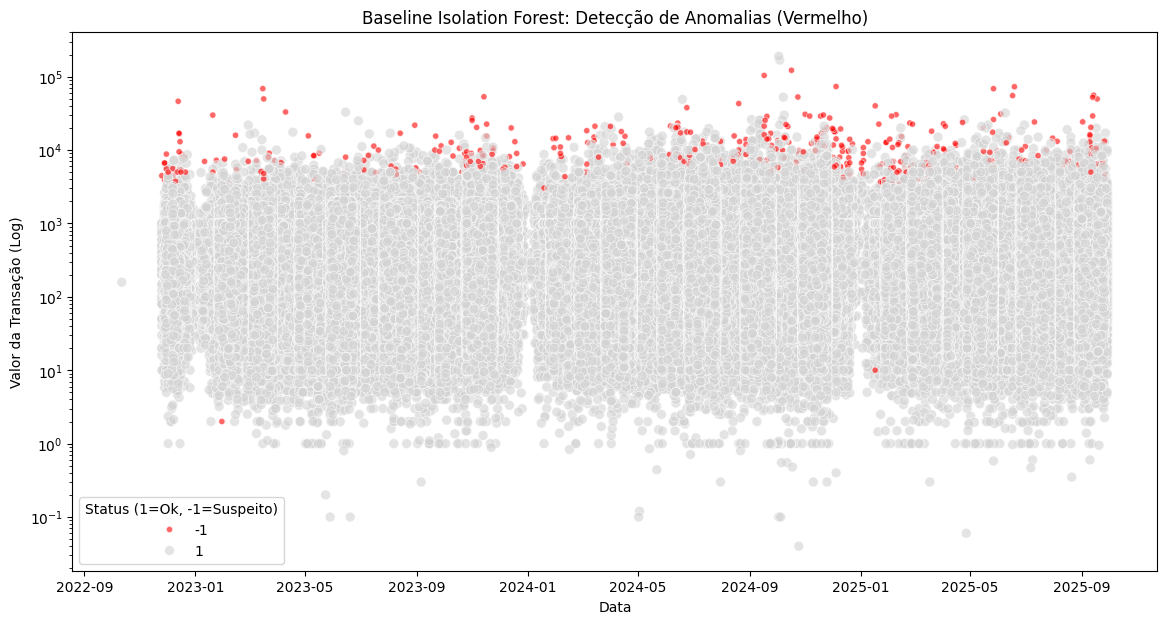

In [414]:
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df_final,
    x='DATA TRANSAÇÃO',
    y='VALOR TRANSAÇÃO',
    hue='IF_LABEL',
    palette={1: 'lightgrey', -1: 'red'},
    alpha=0.6,
    size='IF_LABEL',
    sizes=(20, 50)
)
plt.yscale('log')
plt.title('Baseline Isolation Forest: Detecção de Anomalias (Vermelho)')
plt.ylabel('Valor da Transação (Log)')
plt.xlabel('Data')
plt.legend(title='Status (1=Ok, -1=Suspeito)')
plt.show()